<a href="https://colab.research.google.com/github/mayank5695/Differential-Privacy/blob/master/Global_privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

Install TensorFlow Privacy.

In [0]:
!pip install tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

## Load and pre-process the dataset

Load the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and prepare the data for training.

In [0]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

11493376/11490434 [==============================] - 0s 0us/step


## Define and tune learning model hyperparameters
Set learning model hyperparamter values. 



In [0]:
epochs = 15
batch_size = 250

In [0]:
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

epsilon=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=60000, batch_size=250, noise_multiplier=1.3, epochs=15, delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.3 iterated over 3600 steps satisfies differential privacy with eps = 1.18 and delta = 1e-05.
The optimal RDP order is 17.0.


## Build the learning model

Define a convolutional neural network as the learning model. 

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='same',
                           activation='relu',
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [0]:
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

## Compile and train the learning model


In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

hist=model.fit(train_data, train_labels,
          epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size,verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 79s 1ms/sample - loss: 1.9605 - acc: 0.5756 - val_loss: 1.7105 - val_acc: 0.7850
Epoch 2/15
60000/60000 [==============================] - 72s 1ms/sample - loss: 1.6929 - acc: 0.7846 - val_loss: 1.6582 - val_acc: 0.8139
Epoch 3/15
60000/60000 [==============================] - 73s 1ms/sample - loss: 1.6581 - acc: 0.8092 - val_loss: 1.6423 - val_acc: 0.8236
Epoch 4/15
60000/60000 [==============================] - 72s 1ms/sample - loss: 1.6465 - acc: 0.8176 - val_loss: 1.6348 - val_acc: 0.8304
Epoch 5/15
60000/60000 [==============================] - 72s 1ms/sample - loss: 1.6377 - acc: 0.8264 - val_loss: 1.6309 - val_acc: 0.8320
Epoch 6/15
60000/60000 [==============================] - 72s 1ms/sample - loss: 1.6312 - acc: 0.8329 - val_loss: 1.6213 - val_acc: 0.8407
Epoch 7/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.6256 - acc: 0.8370 - val_loss: 1.

10000/10000 [==============================] - 0s 11us/sample - loss: 1.6081 - acc: 0.8524


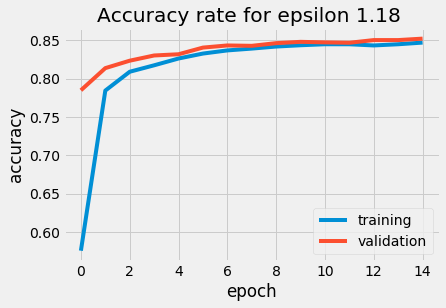

model accuracy :  85.2400004863739


<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt

loss_val,metric_acc=model.evaluate(test_data,test_labels,batch_size=batch_size,verbose=True)

plt.style.use("fivethirtyeight")
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy rate for epsilon 1.18 ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()
plt.savefig('epsilon_1.18.png')
print("model accuracy : ",str(metric_acc*100))

In [0]:
noise_multiplier=[0.7,2.0,5.0,8.0,15.0]
ep=[]
for i in noise_multiplier:
  epsilon=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=60000, batch_size=250, noise_multiplier=i, epochs=15, delta=1e-5)[0]
  ep.append(str(epsilon))


DP-SGD with sampling rate = 0.417% and noise_multiplier = 0.7 iterated over 3600 steps satisfies differential privacy with eps = 4.71 and delta = 1e-05.
The optimal RDP order is 4.5.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 2.0 iterated over 3600 steps satisfies differential privacy with eps = 0.663 and delta = 1e-05.
The optimal RDP order is 35.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 5.0 iterated over 3600 steps satisfies differential privacy with eps = 0.258 and delta = 1e-05.
The optimal RDP order is 128.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 8.0 iterated over 3600 steps satisfies differential privacy with eps = 0.154 and delta = 1e-05.
The optimal RDP order is 128.0.
DP-SGD with sampling rate = 0.417% and noise_multiplier = 15.0 iterated over 3600 steps satisfies differential privacy with eps = 0.081 and delta = 1e-05.
The optimal RDP order is 256.0.


['4.70738549923103',
 '0.6633492797600797',
 '0.2575322196678346',
 '0.15417092583614903',
 '0.08095200247085249']

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 71s 1ms/sample - loss: 1.5949 - acc: 0.8658 - val_loss: 1.5902 - val_acc: 0.8699
Epoch 2/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5942 - acc: 0.8663 - val_loss: 1.5912 - val_acc: 0.8692
Epoch 3/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5942 - acc: 0.8663 - val_loss: 1.5913 - val_acc: 0.8689
Epoch 4/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5934 - acc: 0.8672 - val_loss: 1.5910 - val_acc: 0.8688
Epoch 5/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5923 - acc: 0.8681 - val_loss: 1.5893 - val_acc: 0.8713
Epoch 6/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5919 - acc: 0.8685 - val_loss: 1.5881 - val_acc: 0.8727
Epoch 7/15
60000/60000 [==============================] - 70s 1ms/sample - loss: 1.5907 - acc: 0.8699 - val_loss: 1.

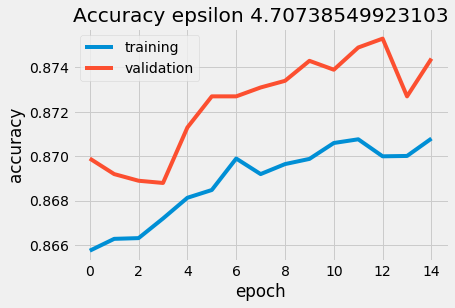

model accuracy :  87.44000196456909
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 69s 1ms/sample - loss: 1.5950 - acc: 0.8656 - val_loss: 1.5983 - val_acc: 0.8619
Epoch 2/15
60000/60000 [==============================] - 69s 1ms/sample - loss: 1.6003 - acc: 0.8602 - val_loss: 1.5998 - val_acc: 0.8608
Epoch 3/15
60000/60000 [==============================] - 69s 1ms/sample - loss: 1.6082 - acc: 0.8522 - val_loss: 1.6040 - val_acc: 0.8572
Epoch 4/15
60000/60000 [==============================] - 69s 1ms/sample - loss: 1.6102 - acc: 0.8505 - val_loss: 1.6058 - val_acc: 0.8546
Epoch 5/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.6148 - acc: 0.8458 - val_loss: 1.6130 - val_acc: 0.8483
Epoch 6/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.6211 - acc: 0.8394 - val_loss: 1.6172 - val_acc: 0.8433
Epoch 7/15
60000/60000 [==============================] - 69s 1ms/sample - loss:

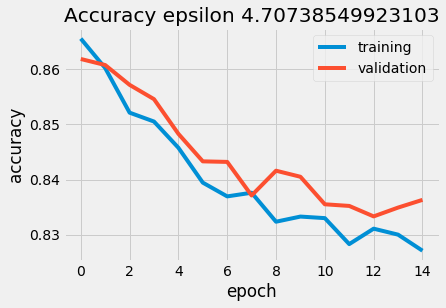

model accuracy :  83.63000154495239
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.7081 - acc: 0.7517 - val_loss: 1.7494 - val_acc: 0.7103
Epoch 2/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.7728 - acc: 0.6870 - val_loss: 1.7786 - val_acc: 0.6815
Epoch 3/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 1.8205 - acc: 0.6392 - val_loss: 1.8234 - val_acc: 0.6375
Epoch 4/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.8566 - acc: 0.6032 - val_loss: 1.8799 - val_acc: 0.5799
Epoch 5/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.8919 - acc: 0.5683 - val_loss: 1.9167 - val_acc: 0.5431
Epoch 6/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 1.9155 - acc: 0.5444 - val_loss: 1.9240 - val_acc: 0.5363
Epoch 7/15
60000/60000 [==============================] - 68s 1ms/sample - loss:

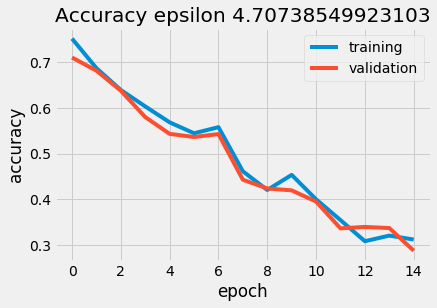

model accuracy :  28.72999906539917
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.2264 - acc: 0.2345 - val_loss: 2.2316 - val_acc: 0.2292
Epoch 2/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.2628 - acc: 0.1982 - val_loss: 2.2768 - val_acc: 0.1843
Epoch 3/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.2589 - acc: 0.2021 - val_loss: 2.2755 - val_acc: 0.1856
Epoch 4/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.2920 - acc: 0.1689 - val_loss: 2.2999 - val_acc: 0.1611
Epoch 5/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.2920 - acc: 0.1690 - val_loss: 2.2366 - val_acc: 0.2244
Epoch 6/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.2585 - acc: 0.2026 - val_loss: 2.2921 - val_acc: 0.1690
Epoch 7/15
60000/60000 [==============================] - 67s 1ms/sample - loss:

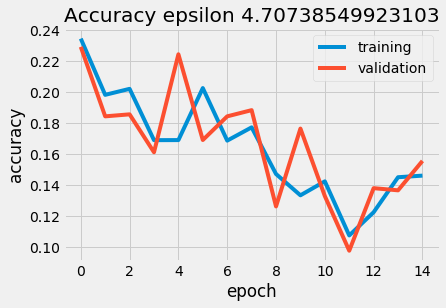

model accuracy :  15.549999475479126
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.3595 - acc: 0.1015 - val_loss: 2.3422 - val_acc: 0.1189
Epoch 2/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.3378 - acc: 0.1234 - val_loss: 2.3087 - val_acc: 0.1524
Epoch 3/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.3268 - acc: 0.1344 - val_loss: 2.3095 - val_acc: 0.1516
Epoch 4/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.3331 - acc: 0.1280 - val_loss: 2.3477 - val_acc: 0.1135
Epoch 5/15
60000/60000 [==============================] - 67s 1ms/sample - loss: 2.3641 - acc: 0.0970 - val_loss: 2.3869 - val_acc: 0.0743
Epoch 6/15
60000/60000 [==============================] - 68s 1ms/sample - loss: 2.3431 - acc: 0.1180 - val_loss: 2.3355 - val_acc: 0.1256
Epoch 7/15
60000/60000 [==============================] - 67s 1ms/sample - loss

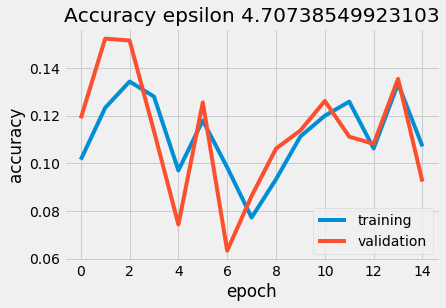

model accuracy :  9.229999780654907


<Figure size 432x288 with 0 Axes>

In [0]:
# check for different noise value and then train and test
import matplotlib.pyplot as plt

for noise in noise_multiplier:
  optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
  loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  
  hist=model.fit(train_data, train_labels,
          epochs=epochs,
          validation_data=(test_data, test_labels),
          batch_size=batch_size,verbose=1)
    
  loss_val,metric_acc=model.evaluate(test_data,test_labels,batch_size=batch_size,verbose=True)
  c=0
  title='Accuracy epsilon '+ep[c]
  plt.style.use("fivethirtyeight")
  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.savefig(title+'.png')
  print("model accuracy : ",str(metric_acc*100))
  c+=1
